In [1]:
# The purpose of this python file is to run k means on five variables: age of diagnosis, bmi, HbA1c, fasting insulin, and fasting glucose
# load libraries
import pandas as pd 
import numpy as np
import os as os

import sklearn as sklearn

import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

if os.getlogin() == "JVARGH7":
    path_nhanes_ckm_folder = "C:/Cloud/OneDrive - Emory University/Papers/NHANES Subtypes Mortality"
elif os.getlogin() == 'JGUO258':
    path_nhanes_ckm_folder = "C:/Users/JGUO258/OneDrive - Emory/NHANES CKM Cascade"
elif os.getlogin() == 'krishnasanaka':
    path_nhanes_ckm_folder = "/Users/krishnasanaka/Library/CloudStorage/OneDrive-Emory/NHANES CKM Cascade"
elif os.getlogin() == 'root':
    path_nhanes_ckm_folder = "/Users/krishnasanaka/Library/CloudStorage/OneDrive-Emory/NHANES CKM Cascade"

# Load the dataset
analytic_dataset = pd.read_csv(path_nhanes_ckm_folder + '/working/all diabetes/ncsen15_knn imputation.csv') 

#----------------------------------------------------------------------------------------------------------------------------------
# cluster variables: "bmi","dm_age","glycohemoglobin","HOMA2 %B","HOMA2 IR"

# List of columns to keep
columns_to_keep = ['dm_age', 'bmi', 'glycohemoglobin', 'homa2b', 'homa2ir', 'ldl', 'hdl', 'triglyceride', 'alt', 'ast', 'sbp', 'dbp', 'egfr', 'waistcircumference']

# Select only the columns you want to keep
analytic_dataset_cluster = analytic_dataset[columns_to_keep].copy()

# Capture the columns that were not used for clustering
other_vars = analytic_dataset.drop(columns=columns_to_keep)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(analytic_dataset[['bmi','dm_age','glycohemoglobin','homa2b', 'homa2ir']])

data_scaled = pd.DataFrame(data_scaled, columns=['bmi','dm_age','glycohemoglobin','homa2b', 'homa2ir'])

# Perform KMeans clustering
kmeans = KMeans(init="random", n_clusters=4, n_init=10, max_iter=300, random_state=57)
kmeans.fit(data_scaled)

# Add cluster labels to the original dataset with selected columns
analytic_dataset_cluster['cluster'] = kmeans.labels_


In [2]:
analytic_dataset_cluster.head()

,dm_age,bmi,glycohemoglobin,homa2b,homa2ir,ldl,hdl,triglyceride,alt,ast,sbp,dbp,egfr,waistcircumference,cluster
0,67.0,25.57,7.6,61.65,2.120204,91.00,44.75,120.25,35.0,24.0,133.333333,70.000000,95.614748,101.05,3
1,61.0,36.94,5.5,105.90,4.237288,133.00,49.00,167.00,26.0,17.0,124.000000,70.666667,91.216314,130.60,1
2,63.0,30.23,8.0,72.85,1.396958,102.75,50.25,116.50,18.0,21.0,171.333333,76.000000,89.312324,99.30,3
3,57.0,23.20,6.7,70.40,2.487562,177.00,66.00,210.00,34.0,28.0,110.666667,68.000000,98.694317,91.00,3
4,57.0,32.14,8.6,96.20,1.821723,81.00,48.25,102.25,23.0,20.0,118.000000,72.000000,80.806291,111.40,3


In [3]:
kmeans_kwargs = { # set the parameters for the kmeans algorithm
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 57,
}

# A list holds the SSE values for each k
sse = [] #initiate an empty list to store the sum of squared errors 
for k in range(1, 11):
    kmeans_kneed = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans_kneed.fit(data_scaled)
    sse.append(kmeans_kneed.inertia_)

# Determining the elbow point in the SSE curve isn’t always straightforward. 
# If you’re having trouble choosing the elbow point of the curve, then you could use a Python package:
# kneed, to identify the elbow point programmatically:

kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print("Elbow point:" + str(kl.elbow)) # returns the elbow point
cluster_summary = analytic_dataset_cluster.groupby('cluster').describe()
print(cluster_summary)


Elbow point:4
         dm_age                                                         bmi  \
          count       mean        std   min   25%   50%   75%   max   count   
cluster                                                                       
0        1021.0  44.718903  13.294416   3.0  36.0  46.0  54.0  81.0  1021.0   
1        1687.0  48.513930  13.581777   3.0  40.0  49.0  59.0  85.0  1687.0   
2        1927.0  38.762844  11.740899   1.0  33.5  42.0  48.0  55.0  1927.0   
3        2863.0  64.975899   8.364874  47.0  58.0  64.0  71.0  85.0  2863.0   

                    ...        egfr             waistcircumference  \
              mean  ...         75%         max              count   
cluster             ...                                              
0        31.339589  ...  111.772739  183.734517             1021.0   
1        39.751472  ...  104.804584  170.122803             1687.0   
2        30.286881  ...  107.685031  153.063349             1927.0   
3        29.

In [4]:


# Relabel the cluster labels based on clinical characteristics
analytic_dataset_cluster['cluster'] = analytic_dataset_cluster['cluster'].replace({0:'SIDD', 1:'SIRD', 2:'MD', 3:'MARD'})

# Concatenate the other variables back to the dataset
analytic_dataset_cluster = pd.concat([analytic_dataset_cluster, other_vars], axis=1)

# Check the final counts for each cluster
analytic_dataset_cluster['cluster'].value_counts()

# Save the dataset with the cluster labels
analytic_dataset_cluster.to_csv(path_nhanes_ckm_folder + '/working/all diabetes/ncsen17_knn clusters.csv', index=False)


In [5]:
cluster_counts = analytic_dataset_cluster['cluster'].value_counts()
print(cluster_counts)

cluster
MARD    2863
MD      1927
SIRD    1687
SIDD    1021
Name: count, dtype: int64


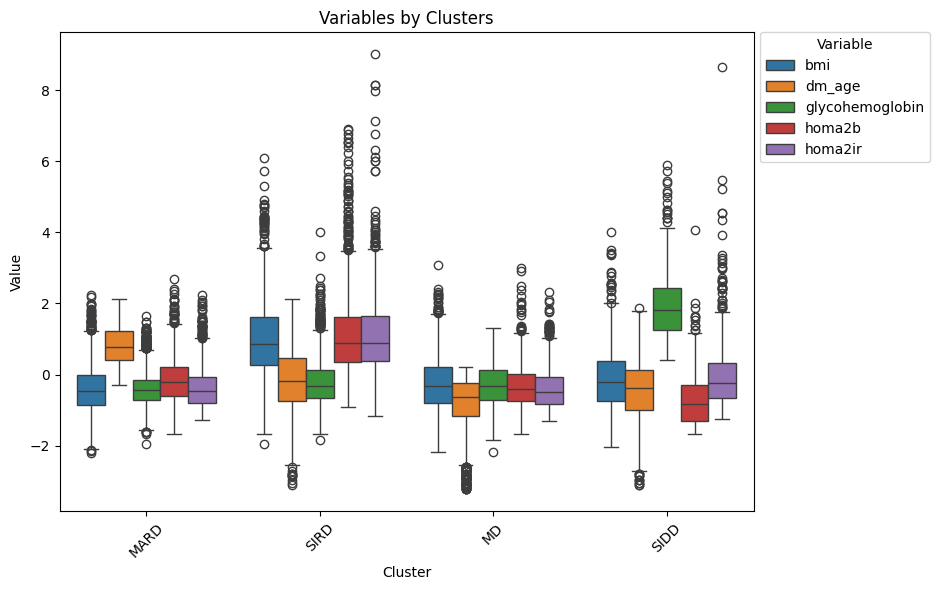

<Figure size 640x480 with 0 Axes>

In [6]:
#----------------------------------------------------------------------------------------------------------------------------------------------
# Plot the clusters
# Add the cluster labels to the copy of the scaled data

data_scaled_cluster = data_scaled.copy()
data_scaled_cluster['cluster'] = kmeans.labels_

# Relabel the cluster labels
data_scaled_cluster['cluster'] = data_scaled_cluster['cluster'].replace({0:'SIDD', 1:'SIRD', 2:'MD', 3:'MARD'})



# Create a new DataFrame with the cluster assignments and variables
data_clustered = pd.concat([data_scaled_cluster['cluster'], data_scaled_cluster[['bmi','dm_age','glycohemoglobin','homa2b','homa2ir']]], axis=1)

# Melt the DataFrame to convert it into long format
data_melted = data_clustered.melt(id_vars='cluster', var_name='Variable', value_name='Value')

# Create the boxplot
plt.figure(figsize=(9.5, 6))  # Adjusted figure size for better layout
sns.boxplot(x='cluster', y='Value', hue='Variable', data=data_melted)
plt.title('Variables by Clusters')
plt.xlabel('Cluster')
plt.ylabel('Value')
plt.xticks(rotation=45)

# Move the legend to the right of the plot
plt.legend(title='Variable', bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

# Save the plot to a file
plt.savefig(path_nhanes_ckm_folder + '/figures/alldm_boxplot_clusters.png', format='png', dpi=300, bbox_inches='tight')

